In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
 !apt-get update

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]


In [4]:
# Installing the spark and all related tools

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark

In [5]:
# setting the environment
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

In [6]:
# Iniating the spark on this notebook
import findspark

In [7]:
findspark.init('/content/spark-3.0.1-bin-hadoop2.7')

In [8]:
from pyspark.sql import SparkSession

#Spark 

In [9]:
spark=SparkSession.builder.appName('final_project').getOrCreate()


## Reading the Data from Cloud





In [12]:
df=spark.read.csv('/content/drive/My Drive/Colab Notebooks/data/SMSSpamCollection',inferSchema=True,sep='\t')

In [13]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)



In [14]:
df.show(50,truncate=False)

+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|_c0 |_c1                                                                                                                                                                                                 |
+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ham |Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...                                                                                     |
|ham |Ok lar... Joking wif u oni...                                                                                                                                                     

In [15]:
df.createOrReplaceTempView('table')

## SQL Queries with Spark

## 1. How many rows are there is this data frame? 5574 rows.

In [16]:
spark.sql("select count(*) \
          from table ").show()

+--------+
|count(1)|
+--------+
|    5574|
+--------+



## Clean and Prepare the Data

In [17]:
df=df.withColumnRenamed('_c0','class').withColumnRenamed('_c1','text')

In [18]:
df.show(truncate=False)

+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|class|text                                                                                                                                                                                                |
+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ham  |Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...                                                                                     |
|ham  |Ok lar... Joking wif u oni...                                                                                                                                                

In [19]:
df.createOrReplaceTempView('t')

## More Queries

# 2. How many word "Love" were in data? 167 

In [20]:
spark.sql("SELECT count(*) FROM t \
          WHERE text LIKE '%love%';").show()

+--------+
|count(1)|
+--------+
|     167|
+--------+



# 3. How many sentences there were where they had "I love you " in that text in the data ? 19 messages had this sentences.

In [21]:
spark.sql("SELECT count(*) FROM t \
          WHERE text LIKE '%I love you%';").show()

+--------+
|count(1)|
+--------+
|      19|
+--------+



# 4. What was the class detected that "I love you" sentences were in those texts? All were observed as a Ham sms.

In [22]:
spark.sql("SELECT * FROM t \
          WHERE text LIKE '%I love you%';").show()

+-----+--------------------+
|class|                text|
+-----+--------------------+
|  ham|Did I forget to t...|
|  ham|Hello my boytoy ....|
|  ham|Geeeee ... I love...|
|  ham|I wonder if your ...|
|  ham|Wow ... I love yo...|
|  ham|I love you. You s...|
|  ham|Do have a nice da...|
|  ham|I love your ass! ...|
|  ham|Hey ! I want you ...|
|  ham|BABE !!! I miiiii...|
|  ham|I thank you so mu...|
|  ham|Mmmmm ... It was ...|
|  ham|I love you both t...|
|  ham|Hey loverboy! I l...|
|  ham|I love you !!! Yo...|
|  ham|I miss you so muc...|
|  ham|Mmmmmm ... I love...|
|  ham|Don't forget thou...|
|  ham|I wish things wer...|
+-----+--------------------+



# 5. How many textx messages were Spam and also there was using the word "lick" in it? Thre were 4 Spam messages in total that has been using the word "lick" in it.

In [23]:
spark.sql("SELECT count(class) FROM t \
          WHERE t.class=='spam' AND t.text LIKE '%lick%' ").show()

+------------+
|count(class)|
+------------+
|           4|
+------------+



In [24]:
from pyspark.sql.functions import length

## Applying the Length Function on Each Text

In [25]:
df=df.withColumn('length',length(df['text']))

In [26]:
df.show()

+-----+--------------------+------+
|class|                text|length|
+-----+--------------------+------+
|  ham|Go until jurong p...|   111|
|  ham|Ok lar... Joking ...|    29|
| spam|Free entry in 2 a...|   155|
|  ham|U dun say so earl...|    49|
|  ham|Nah I don't think...|    61|
| spam|FreeMsg Hey there...|   147|
|  ham|Even my brother i...|    77|
|  ham|As per your reque...|   160|
| spam|WINNER!! As a val...|   157|
| spam|Had your mobile 1...|   154|
|  ham|I'm gonna be home...|   109|
| spam|SIX chances to wi...|   136|
| spam|URGENT! You have ...|   155|
|  ham|I've been searchi...|   196|
|  ham|I HAVE A DATE ON ...|    35|
| spam|XXXMobileMovieClu...|   149|
|  ham|Oh k...i'm watchi...|    26|
|  ham|Eh u remember how...|    81|
|  ham|Fine if thats th...|    56|
| spam|England v Macedon...|   155|
+-----+--------------------+------+
only showing top 20 rows



## Clearly the Ham Messages Have a Lower Length than the Spam Messages

In [ ]:
df.groupby('class').mean().show()

+-----+-----------------+
|class|      avg(length)|
+-----+-----------------+
|  ham|71.45431945307645|
| spam|138.6706827309237|
+-----+-----------------+



## Importing the Needed Libraries 

In [27]:
# Needed libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline


In [28]:
df_pandas=df.toPandas()

## Clearly it is showing in both histograms that the Spams mostly are more than 150 words in case the most Ham texts are less than 150 words.

# Histograms


<Figure size 1440x576 with 0 Axes>

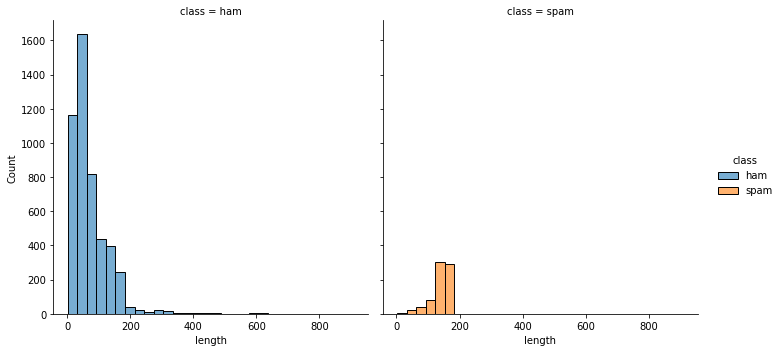

In [30]:
plt.figure(figsize=(20,8))
sns.displot(df_pandas, x='length', hue="class",bins=30,alpha=.6,multiple="dodge",col='class')
plt.show()


# Ham Vs Spam

<Figure size 1440x576 with 0 Axes>

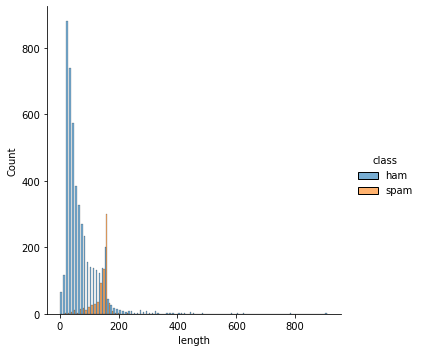

In [32]:
plt.figure(figsize=(20,8))
sns.displot(df_pandas, x='length', hue="class",bins=50,alpha=.6,multiple="dodge", binwidth=10)
plt.show()

## Distribution of the Features 

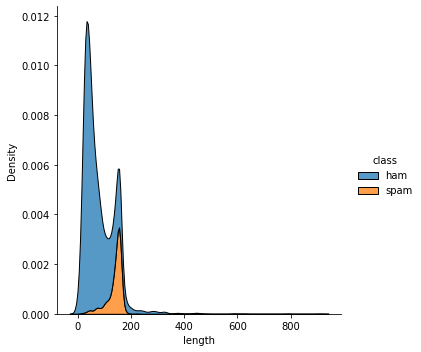

In [33]:
sns.displot(df_pandas, x='length', kind="kde",hue='class',multiple="stack")

# Feature Transfromation

## Tokenizer,StopWordsRemover,CountVectorizer,IDF,StringIndexer

In [35]:
from pyspark.ml.feature import Tokenizer,StopWordsRemover,CountVectorizer,IDF,StringIndexer

In [36]:
tokenizer = Tokenizer(inputCol="text", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
count_vec = CountVectorizer(inputCol='stop_tokens',outputCol='c_vec')
idf = IDF(inputCol="c_vec", outputCol="tf_idf")
ham_spam_to_num = StringIndexer(inputCol='class',outputCol='label')

In [37]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector

# Clean Up the Data

In [42]:
cleanedData = VectorAssembler(inputCols=['tf_idf','length'],outputCol='features')

# Model

# Naive Bayes

In [43]:
from pyspark.ml.classification import NaiveBayes

In [44]:
# Use defaults
nb = NaiveBayes()

# Pipeline

In [39]:
from pyspark.ml import Pipeline

In [45]:
data_prep_pipe = Pipeline(stages=[ham_spam_to_num,tokenizer,stopremove,count_vec,idf,cleanedData])

In [46]:
cleaner = data_prep_pipe.fit(df)

In [47]:
clean_data = cleaner.transform(df)

# Train and Evaluation

In [48]:
clean_data.show()

+-----+--------------------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|class|                text|length|label|          token_text|         stop_tokens|               c_vec|              tf_idf|            features|
+-----+--------------------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|  ham|Go until jurong p...|   111|  0.0|[go, until, juron...|[go, jurong, poin...|(13423,[7,11,31,6...|(13423,[7,11,31,6...|(13424,[7,11,31,6...|
|  ham|Ok lar... Joking ...|    29|  0.0|[ok, lar..., joki...|[ok, lar..., joki...|(13423,[0,24,297,...|(13423,[0,24,297,...|(13424,[0,24,297,...|
| spam|Free entry in 2 a...|   155|  1.0|[free, entry, in,...|[free, entry, 2, ...|(13423,[2,13,19,3...|(13423,[2,13,19,3...|(13424,[2,13,19,3...|
|  ham|U dun say so earl...|    49|  0.0|[u, dun, say, so,...|[u, dun, say, ear...|(13423,[0,70,80,1...|(13423,[0,70,8

In [49]:
clean_data = clean_data.select(['label','features'])

# Vectorized Data, Ready ti fit the Model

In [50]:
clean_data.show(40,truncate=False)

+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
+-----

# Split and Fitting the Data 

In [51]:
(training,testing) = clean_data.randomSplit([0.7,0.3])

In [52]:
spam_predictor = nb.fit(training)

In [53]:
df.printSchema()

root
 |-- class: string (nullable = true)
 |-- text: string (nullable = true)
 |-- length: integer (nullable = true)



In [54]:
test_results = spam_predictor.transform(testing)

In [55]:
test_results.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(13424,[0,1,14,31...|[-218.42139575785...|[1.0,4.1253117916...|       0.0|
|  0.0|(13424,[0,1,20,27...|[-972.72274973886...|[1.0,4.8058041016...|       0.0|
|  0.0|(13424,[0,1,21,27...|[-750.57452194974...|[1.0,7.5755951094...|       0.0|
|  0.0|(13424,[0,1,23,63...|[-1309.8364942103...|[1.0,1.5935943591...|       0.0|
|  0.0|(13424,[0,1,24,31...|[-356.23115975709...|[1.0,1.5083158009...|       0.0|
|  0.0|(13424,[0,1,27,88...|[-1524.4837075990...|[1.03095559490770...|       1.0|
|  0.0|(13424,[0,1,30,12...|[-600.50816776760...|[1.0,3.8787327375...|       0.0|
|  0.0|(13424,[0,1,31,43...|[-337.80543485110...|[1.0,3.1063184408...|       0.0|
|  0.0|(13424,[0,1,43,69...|[-630.13790402312...|[0.00181752980442...|       1.0|
|  0.0|(13424,[0

In [56]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluation the Test Data

In [57]:
acc_eval = MulticlassClassificationEvaluator()
acc = acc_eval.evaluate(test_results)
print("Accuracy of model at predicting spam was: {:.2f}".format(acc))

Accuracy of model at predicting spam was: 0.92


## Found an accuracy of 92 % of our analysys. The model is ready for practicinfg on further sample messages in future.